In [124]:
import pandas as pd
import urllib.request, json 
import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import numpy as np
from numpy import nan as Nan
from IPython.display import Markdown, display
import locale
import ipywidgets as widgets
from IPython.display import display
import math
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

locale.setlocale(locale.LC_ALL, 'en_US')

def printmd(string):
    display(Markdown(string))

def getlatest(df, column):
    latest_date = df.max()['data']
    latest_but_one_date = df[df['data'] != latest_date].max()['data']

    try:
        latest_value = int(df[df['data'] == latest_date][column].values[0])
        latest_but_one_value = int(df[df['data'] == latest_but_one_date][column].values[0])
    except Exception as e:
        print("Exception: {}".format(e))
    sign_char = ""
    try:
        if latest_value >= latest_but_one_value:
            sign_char = "+"
        if latest_but_one_value == 0:
            incr_perc = "--"
        else:
            incr_perc = "{}{:.2f}%".format(sign_char, 100*(latest_value-latest_but_one_value)/latest_but_one_value)
    except Exception as e:
        print("Exception: {}".format(e))
        print("Column: {} - Latest value: {} - Latest but one value: {}".format(column, latest_value, latest_but_one_value))
    return "{} [{}]".format(locale.format_string("%d", latest_value, grouping=True), incr_perc)

NAT_JSON_URL = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-andamento-nazionale.json"
NAT_TXT_URL = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"

with urllib.request.urlopen(NAT_JSON_URL) as url:
	data = json.loads(url.read().decode())

df = pd.DataFrame.from_dict(data)

summary_dict = {'totale_casi': "Totale casi", 
                'totale_attualmente_positivi': "Totale attualmente positivi",
               'nuovi_attualmente_positivi': "Nuovi attualmente positivi",
               'deceduti': "Deceduti",
               'terapia_intensiva': "Terapia Intensiva",
               'ricoverati_con_sintomi': "Ricoverati con sintomi",
               'totale_ospedalizzati': "Totale ospedalizzati",
               'isolamento_domiciliare': "Isolamente domiciliare",
               'dimessi_guariti': "Dimessi guariti",
               'tamponi': "Tamponi"}

latest_date = df.max()['data']
printmd("<span style='color:red;font-weight:bold;font-size:26px;'>DATI NAZIONALI </span><BR>")
printmd("<span style='color:black;font-weight:bold;font-size:18px;'>Aggiornamento: </span><span style='color:blue;font-weight:bold;font-size:18px'>{}</span>".format(latest_date))
for key in summary_dict:
    printmd("<span style='color:black;font-weight:bold;font-size:18px'>{}:  </span><span style='color:blue;font-weight:bold;font-size:20px'>{}</span>".format(summary_dict[key], getlatest(df, key)))

printmd("<HR>")


<span style='color:red;font-weight:bold;font-size:26px;'>DATI NAZIONALI </span><BR>

<span style='color:black;font-weight:bold;font-size:18px;'>Aggiornamento: </span><span style='color:blue;font-weight:bold;font-size:18px'>2020-03-31T17:00:00</span>

<span style='color:black;font-weight:bold;font-size:18px'>Totale casi:  </span><span style='color:blue;font-weight:bold;font-size:20px'>105,792 [+3.98%]</span>

Exception: 'totale_attualmente_positivi'
Exception: local variable 'latest_value' referenced before assignment


UnboundLocalError: local variable 'latest_value' referenced before assignment

In [94]:
# data staging
df2 = df['deceduti']
nuovi_deceduti = df2.diff(periods=1);
nuovi_deceduti[0]=0

#myDates = [datetime.datetime.strptime(d,"%Y-%m-%d %H:%M:%S").date() for d in df['data']]
myDates = [datetime.datetime.strptime(d,"%Y-%m-%dT%H:%M:%S").date() for d in df['data']]

myValues_TAP_TD = [int(x)+int(y) for x,y in zip(df['totale_attualmente_positivi'], df['deceduti'])]
myValues_TAP = [int(x) for x in df['totale_attualmente_positivi']]

myValues_NAP_ND = [int(x)+int(y) for x,y in zip(df['nuovi_attualmente_positivi'], nuovi_deceduti)]
myValues_NAP = [int(x) for x in df['nuovi_attualmente_positivi']]

In [95]:
def esperimenti_interpolazione():
    s2_dict = {"data": ["2020-03-22 18:00:00"],
               "stato":["ITA"],
               'totale_casi': [None],
               'totale_attualmente_positivi': [None],
               'nuovi_attualmente_positivi': [None],
               'deceduti': [None],
               'terapia_intensiva': [None],
               'ricoverati_con_sintomi': [None],
               'totale_ospedalizzati': [None],
               'isolamento_domiciliare': [None],
               'dimessi_guariti': [None],
               'tamponi': [None]}

    s2 = pd.DataFrame.from_dict(s2_dict)

    df2 = df.append(s2, ignore_index=True)
    #df2.interpolate()
    df2.infer_objects().interpolate(method='linear')
    #pd.concat(df, s2, ignore_index=True)
    #df.interpolate()
    from scipy.interpolate import interp1d
    x = np.linspace(0, 1, num=len(myDates), endpoint=True)
    f = interp1d(x, np.array(myValues_TAP))
    x2 = np.linspace(0, 1, num=len(myDates), endpoint=True)

    plt.plot(x2, myValues_TAP, 'o', x2, f(x2), '-')
    
# iterating over rows using iterrows() function 
df_shift_perc = df.copy()
df_shift_diff = df.copy()
#print(df_shift_perc.dtypes)

for key, value in df_shift_perc.iteritems(): 
    #print("key = {} - value = {}".format(key, value))
    if df_shift_perc.dtypes[key] == 'int64':
        #print("Changing type of column {} to string".format(key))
        df_shift_perc[key] = df_shift_perc[key].astype('str')
    for key2, value2 in value.iteritems():
        #print("key = {} - key2 = {} - value2 = {} - type = {}".format(key, key2, value2, df_shift_perc.dtypes[key]))
        if key in ['ricoverati_con_sintomi', 'terapia_intensiva', 'totale_ospedalizzati', 'isolamento_domiciliare',
                   'totale_attualmente_positivi', 'nuovi_attualmente_positivi', 'dimessi_guariti', 'deceduti',
                   'totale_casi', 'tamponi']:
            if key2 == 0:
                ratio = 100
            else:
                ratio = 100 * (pd.to_numeric(df.iloc[key2][key]) / pd.to_numeric(df.iloc[key2-1][key]) - 1)
            df_shift_perc.at[key2, key] = "{:.0f}%".format(ratio)
            #print("XXXXX key = {} - key2 = {} - ratio = {}, new value = {}".format(key, key2, ratio, df_shift_perc.iloc[key2][key]))

for key, value in df_shift_diff.iteritems(): 
    #print("key = {} - value = {}".format(key, value))
    if df_shift_diff.dtypes[key] == 'int64':
        #print("Changing type of column {} to string".format(key))
        df_shift_diff[key] = df_shift_diff[key].astype('str')
    for key2, value2 in value.iteritems():
        #print("key = {} - key2 = {} - value2 = {} - type = {}".format(key, key2, value2, df_shift_perc.dtypes[key]))
        if key in ['ricoverati_con_sintomi', 'terapia_intensiva', 'totale_ospedalizzati', 'isolamento_domiciliare',
                   'totale_attualmente_positivi', 'nuovi_attualmente_positivi', 'dimessi_guariti', 'deceduti',
                   'totale_casi', 'tamponi']:
            diff = pd.to_numeric(df.iloc[key2][key]) - pd.to_numeric(df.iloc[key2-1][key])
            df_shift_diff.at[key2, key] = diff
            #print("XXXXX key = {} - key2 = {} - ratio = {}, new value = {}".format(key, key2, ratio, df_shift_perc.iloc[key2][key]))


printmd("<span style='color:black;font-weight:bold;font-size:24px;'>DATI NAZIONALI: ULTIMI INCREMENTI % SU BASE QUOTIDIANA</span><BR>") 
df_shift_perc = df_shift_perc[['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva', 'totale_ospedalizzati', 'isolamento_domiciliare',
                   'totale_attualmente_positivi', 'nuovi_attualmente_positivi', 'dimessi_guariti', 'deceduti',
                   'totale_casi', 'tamponi']]
df_shift_perc.drop(df.index[0]).tail()



<span style='color:black;font-weight:bold;font-size:24px;'>DATI NAZIONALI: ULTIMI INCREMENTI % SU BASE QUOTIDIANA</span><BR>

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
31,2020-03-26T17:00:00,ITA,7%,4%,7%,9%,8%,29%,11%,9%,8%,11%
32,2020-03-27T17:00:00,ITA,5%,3%,5%,9%,7%,-2%,6%,12%,7%,9%
33,2020-03-28T17:00:00,ITA,2%,3%,3%,8%,5%,-17%,13%,10%,7%,9%
34,2020-03-29T17:00:00,ITA,3%,1%,2%,8%,5%,4%,5%,8%,6%,6%
35,2020-03-30T17:00:00,ITA,1%,2%,2%,3%,2%,-57%,12%,8%,4%,5%


In [96]:
printmd("<span style='color:black;font-weight:bold;font-size:24px;'>DATI NAZIONALI: ULTIMI INCREMENTI SU BASE QUOTIDIANA</span><BR>") 
df_shift_diff = df_shift_diff[['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva', 'totale_ospedalizzati', 'isolamento_domiciliare',
                   'totale_attualmente_positivi', 'nuovi_attualmente_positivi', 'dimessi_guariti', 'deceduti',
                   'totale_casi', 'tamponi']]
df_shift_diff.drop(df.index[0]).tail()


<span style='color:black;font-weight:bold;font-size:24px;'>DATI NAZIONALI: ULTIMI INCREMENTI SU BASE QUOTIDIANA</span><BR>

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
31,2020-03-26T17:00:00,ITA,1641,123,1764,2728,4492,1001,999,662,6153,36615
32,2020-03-27T17:00:00,ITA,1276,120,1396,3005,4401,-91,589,969,5959,33019
33,2020-03-28T17:00:00,ITA,647,124,771,2880,3651,-750,1434,889,5974,35447
34,2020-03-29T17:00:00,ITA,710,50,760,3055,3815,164,646,756,5217,24504
35,2020-03-30T17:00:00,ITA,409,75,484,1164,1648,-2167,1590,812,4050,23329


In [97]:
r0_NAP = []
for idx, value in enumerate(myValues_NAP):
    if idx == 0:
        r0_NAP.append(myValues_NAP[1] / myValues_NAP[0])
    else:
        r0_NAP.append(value / myValues_NAP[idx-1])

In [98]:
# title = 'DATI NAZIONALI\nTOTALE ATTUALMENTE POSITIVI + TOTALE DECEDUTI'
# xlabel = 'Giorno'
# ylabel = 'Valore accumulato'
# xseries = myDates
# yseries1 = myValues_TAP_TD
# label1 = "Totale Deceduti"
# yseries2 = myValues_TAP
# label2 = "Totale Attualmente Positivi"
def bar_chart(title, xlabel, ylabel, xseries, yseries1, label1, yseries2, label2, xdates = True):
    
    fig, ax = plt.subplots()
    plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large', 'legend.fontsize': 'x-large'})
    fig.set_size_inches(18.5, 10.5)
    fig.suptitle(title, fontsize=24, fontweight='bold')
    ax.set_xlabel(xlabel, horizontalalignment='center', fontsize=18, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=18, fontweight='bold')

    # first series
    ax.bar(xseries, yseries1, label=label1)
    # second series
    ax.bar(xseries, yseries2, label=label2)

    if xdates == True:
        myFmt = DateFormatter("%d %b")
        ax.xaxis.set_major_formatter(myFmt)
        ## Rotate date labels automatically
        fig.autofmt_xdate()

    # zip joins x and y coordinates in pairs
    for x,y,z in zip(xseries, yseries1, yseries2):

        label = "{:.0f}".format(y-z)

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,15), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

    # zip joins x and y coordinates in pairs
    for x,y in zip(xseries, yseries2):

        label = "{:.0f}".format(y)

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,-20), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    ax.grid(True)
    ax.legend()

    plt.show()


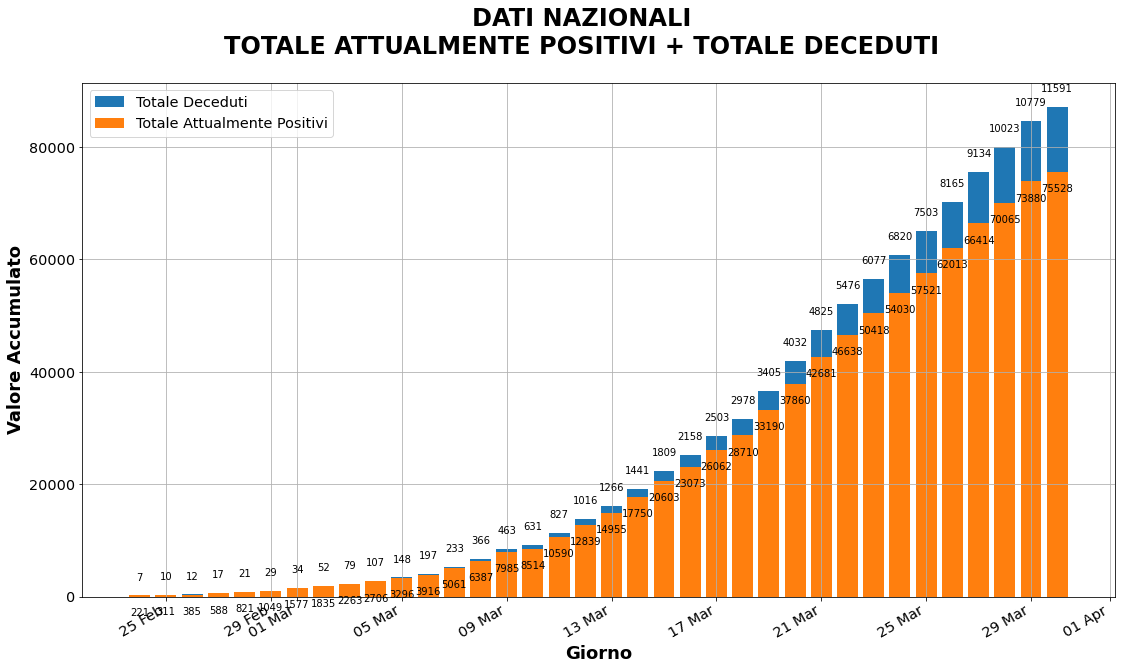

<HR>

In [99]:
bar_chart(title = 'DATI NAZIONALI\nTOTALE ATTUALMENTE POSITIVI + TOTALE DECEDUTI',
          xlabel = 'Giorno',
          ylabel = 'Valore Accumulato',
          xseries = myDates,
          yseries1 = myValues_TAP_TD,
          label1 = "Totale Deceduti",
          yseries2 = myValues_TAP,
          label2 = "Totale Attualmente Positivi", 
          xdates = True)
printmd("<HR>")

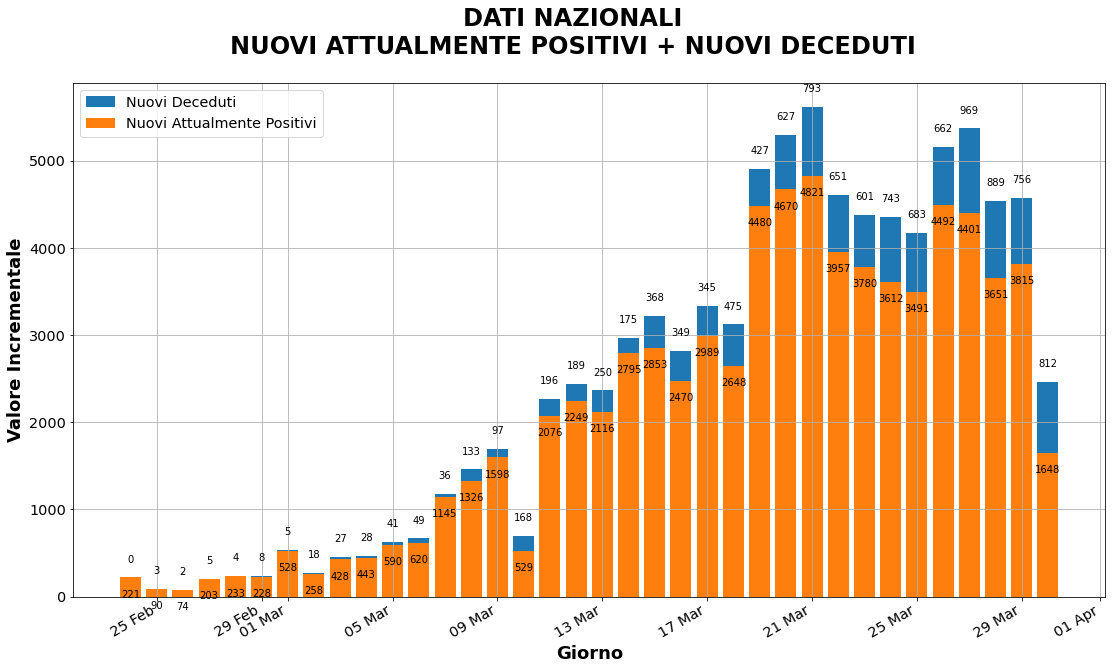

<HR>

In [100]:
bar_chart(title = 'DATI NAZIONALI\nNUOVI ATTUALMENTE POSITIVI + NUOVI DECEDUTI',
          xlabel = 'Giorno',
          ylabel = 'Valore Incrementale',
          xseries = myDates,
          yseries1 = myValues_NAP_ND,
          label1 = "Nuovi Deceduti",
          yseries2 = myValues_NAP,
          label2 = "Nuovi Attualmente Positivi", 
          xdates = True)
printmd("<HR>")

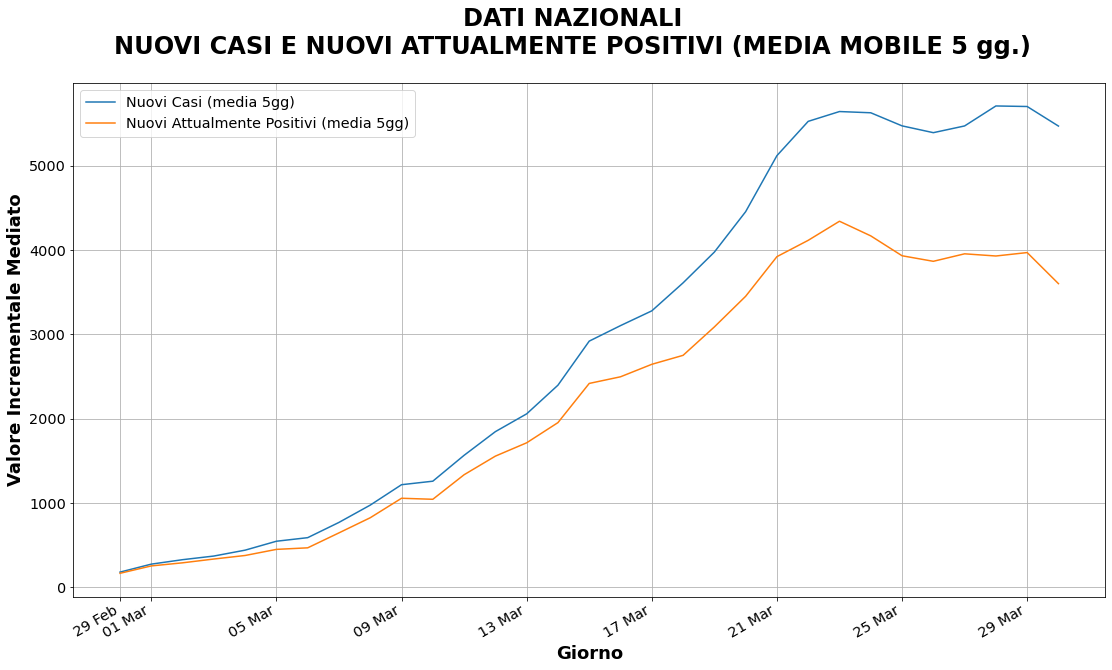

In [101]:
def calc_moving_average(df, column, avg_length = 5):
    myValues_avg = []
    for i in range(0, len(df[column])):
        value = 0
        if i < avg_length-1:
            for j in range(0,i+1):
                #print("+1")
                value += df[column][j]
            #print("dividing by {}".format(i+1))
            value /= (i+1)
        else:
            for j in range(i-avg_length+1,i+1):
                #print("+1")
                value += df[column][j]
            #print("dividing by {}".format(avg_length))
            value /= avg_length
        myValues_avg.append(value)
    return myValues_avg
    

# NAP Media mobile
AVG_LENGTH = 5
myValues_NAP_avg = calc_moving_average(df, 'nuovi_attualmente_positivi', AVG_LENGTH)
myValues_TCdiff_avg = calc_moving_average(df_shift_diff, 'totale_casi', AVG_LENGTH)

def plot_chart(title, xlabel, ylabel, xseries, yseries1, label1, yseries2, label2, xdates = True):
    fig, ax = plt.subplots()
    plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large', 'legend.fontsize': 'x-large'})
    fig.set_size_inches(18.5, 10.5)
    fig.suptitle(title, fontsize=24, fontweight='bold')
    ax.set_xlabel(xlabel, horizontalalignment='center', fontsize=18, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=18, fontweight='bold')
    ax.plot(xseries, yseries1, label=label1)
    if yseries2 is not None:
        ax.plot(xseries, yseries2, label=label2)
    ax.grid(True)
    if xdates is True:
        myFmt = DateFormatter("%d %b")
        ax.xaxis.set_major_formatter(myFmt)
        ## Rotate date labels automatically
        fig.autofmt_xdate()
    ax.legend()
    plt.show()

plot_chart(title = 'DATI NAZIONALI\nNUOVI CASI E NUOVI ATTUALMENTE POSITIVI (MEDIA MOBILE {} gg.)'.format(AVG_LENGTH),
           xlabel = 'Giorno',
           ylabel = 'Valore Incrementale Mediato', 
           xseries = myDates[AVG_LENGTH:],
           yseries1 = myValues_TCdiff_avg[AVG_LENGTH:],
           label1 = "Nuovi Casi (media {}gg)".format(AVG_LENGTH),
           yseries2 = myValues_NAP_avg[AVG_LENGTH:],
           label2 = "Nuovi Attualmente Positivi (media {}gg)".format(AVG_LENGTH),
           xdates = True)



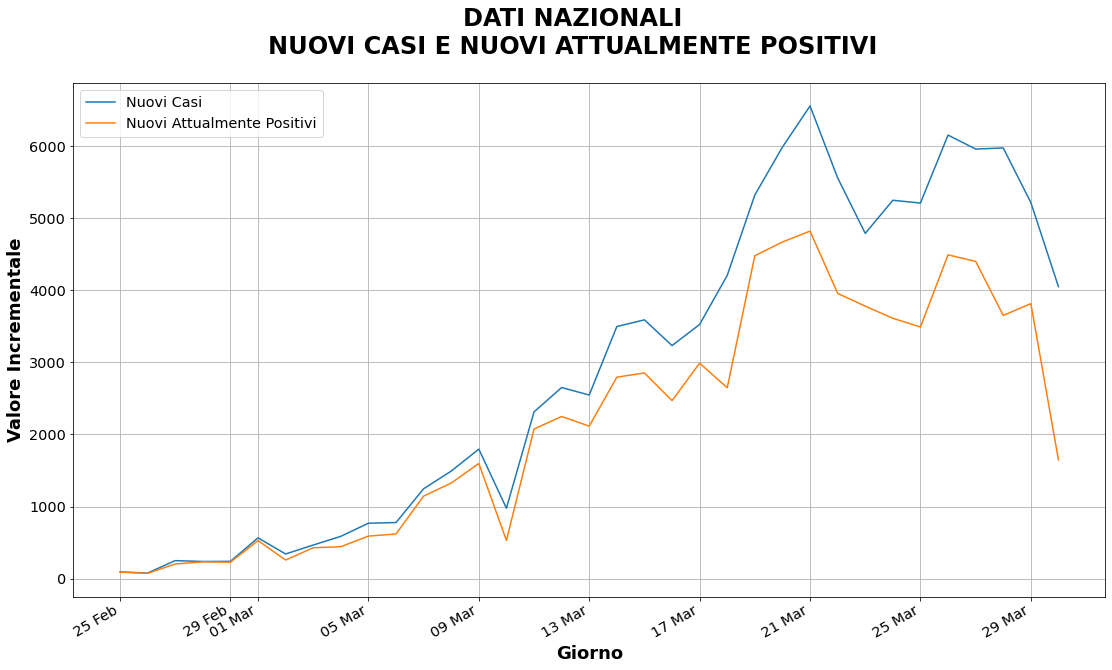

In [102]:
plot_chart(title = 'DATI NAZIONALI\nNUOVI CASI E NUOVI ATTUALMENTE POSITIVI'.format(AVG_LENGTH),
           xlabel = 'Giorno',
           ylabel = 'Valore Incrementale', 
           xseries = myDates[1:],
           yseries1 = df_shift_diff['totale_casi'][1:],
           label1 = "Nuovi Casi",
           yseries2 = df['nuovi_attualmente_positivi'][1:],
           label2 = "Nuovi Attualmente Positivi",
           xdates = True)



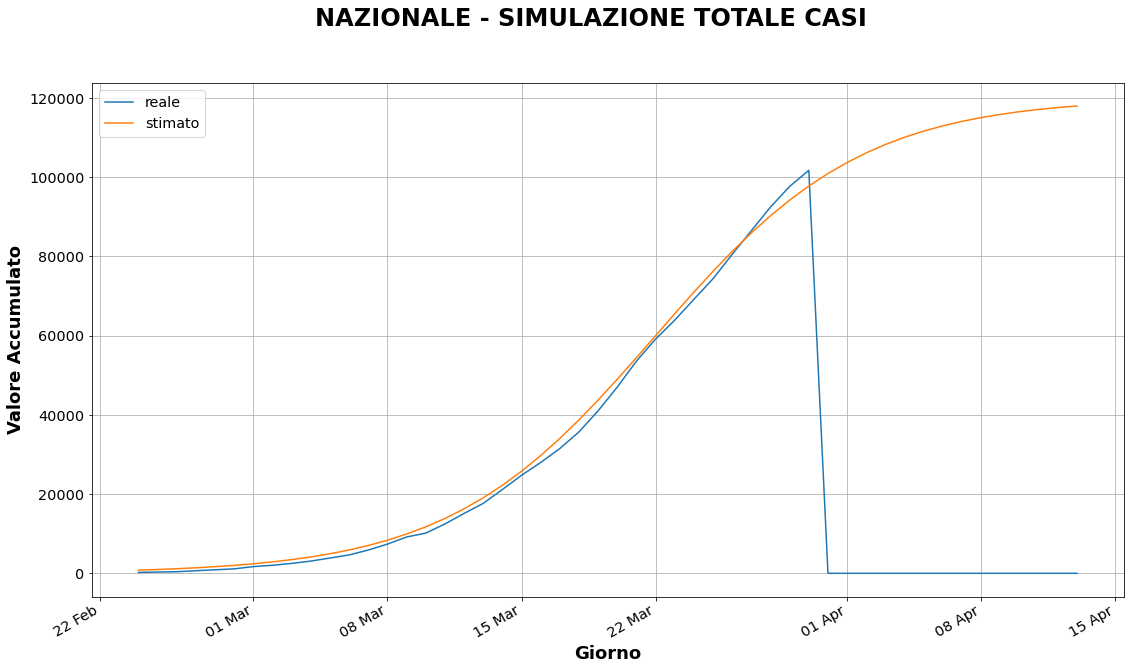

<span style='color:black;font-weight:bold;font-size:18px'>Current Error: 3.9% </span>

<HR>

In [103]:
#myDates_sim = [datetime.datetime.strptime(d,"%Y-%m-%d %H:%M:%S").date() for d in df['data']]
myDates_sim = [datetime.datetime.strptime(d,"%Y-%m-%dT%H:%M:%S").date() for d in df['data']]



myValues_TC = [int(x) for x in df['totale_casi']]

STEP = 27
A = 120000
POINTS = 50

x_axis_simul = [(-5 + 5*i/STEP) for i in range(0,POINTS)]
y_axis_simul = [A / ( 1 + math.exp(-x)) for x in x_axis_simul]

errore = myValues_TC[len(myDates_sim)-1] - y_axis_simul[len(myDates_sim)-1]
errore_perc = errore / myValues_TC[len(myDates_sim)-1]

if POINTS > len(myDates_sim):
    for i in range(len(myDates_sim), POINTS):      
        last_date = myDates_sim[i-1]
        new_date_time = last_date + datetime.timedelta(days=1)
        #print("i = {} : {} --> {}".format(i, myDates[i-1], new_date_time))
        myDates_sim.append(new_date_time)
        
if POINTS > len(myValues_TC):
    for i in range(len(myValues_TC), POINTS):
        myValues_TC.append(0)

fig, ax = plt.subplots()
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large', 'legend.fontsize': 'x-large'})
fig.set_size_inches(18.5, 10.5)
fig.suptitle('NAZIONALE - SIMULAZIONE TOTALE CASI', fontsize=24, fontweight='bold')
ax.set_xlabel('Giorno', horizontalalignment='center', fontsize=18, fontweight='bold')
ax.set_ylabel('Valore Accumulato', fontsize=18, fontweight='bold')

ax.plot(myDates_sim, myValues_TC, label="reale")
ax.plot(myDates_sim, y_axis_simul, label="stimato")
ax.grid(True)

myFmt = DateFormatter("%d %b")
ax.xaxis.set_major_formatter(myFmt)

## Rotate date labels automatically
fig.autofmt_xdate()

ax.legend()

plt.show()
printmd("<span style='color:black;font-weight:bold;font-size:18px'>Current Error: {:.1f}% </span>".format(100*errore_perc))

printmd("<HR>")

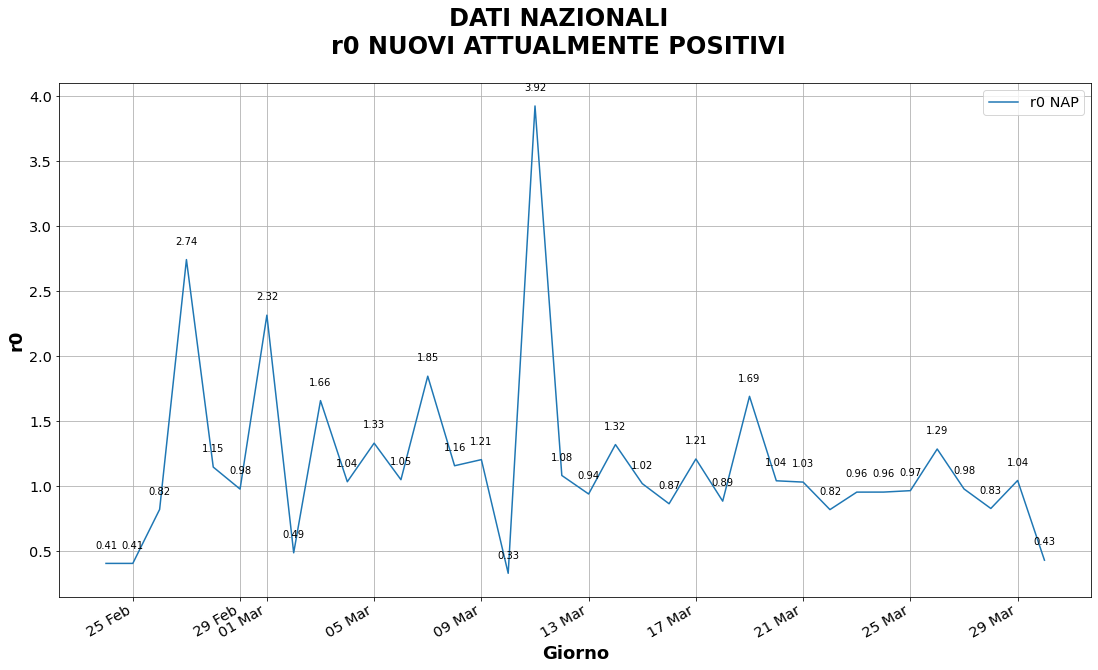

<HR>

In [104]:
fig, ax = plt.subplots()
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large', 'legend.fontsize': 'x-large'})
fig.set_size_inches(18.5, 10.5)
fig.suptitle('DATI NAZIONALI\nr0 NUOVI ATTUALMENTE POSITIVI', fontsize=24, fontweight='bold')
ax.set_xlabel('Giorno', horizontalalignment='center', fontsize=18, fontweight='bold')
ax.set_ylabel('r0', fontsize=18, fontweight='bold')

ax.plot(myDates, r0_NAP, label="r0 NAP")

for x,y in zip(myDates, r0_NAP):
    if y is None:
        label = ""
    else:
        label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,15), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

myFmt = DateFormatter("%d %b")
ax.xaxis.set_major_formatter(myFmt)

## Rotate date labels automatically
fig.autofmt_xdate()

ax.grid(True)
ax.legend()

plt.show()
printmd("<HR>")

In [105]:
# regional data staging
REG_JSON_URL = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-regioni.json"

with urllib.request.urlopen(REG_JSON_URL) as url:
	data_reg = json.loads(url.read().decode())

df_reg = pd.DataFrame.from_dict(data_reg)

latest_date = df_reg.max()['data']
latest_but_one_date = df_reg[df_reg['data'] != latest_date].max()['data']

df_reg_latest = df_reg[df_reg['data'] == latest_date]
df_reg_latest_but_one = df_reg[df_reg['data'] == latest_but_one_date]

def float_0(value):
    v_float = float(value)
    if v_float == 0:
        return 1
    return v_float

myRegions = [regione for regione in df_reg_latest['denominazione_regione']]
myValues_NAP_ND = [int(df_reg_latest[df_reg_latest['denominazione_regione'] == regione]["nuovi_attualmente_positivi"]) + int(df_reg_latest[df_reg_latest['denominazione_regione'] == regione]["deceduti"]) - int(df_reg_latest_but_one[df_reg_latest_but_one['denominazione_regione'] == regione]["deceduti"]) for regione in df_reg_latest['denominazione_regione']]
myValues_NAP = [int(df_reg_latest[df_reg_latest['denominazione_regione'] == regione]["nuovi_attualmente_positivi"]) for regione in df_reg_latest['denominazione_regione']]
myValues_TAP_TD = [int(df_reg_latest[df_reg_latest['denominazione_regione'] == regione]["totale_attualmente_positivi"]) + int(df_reg_latest[df_reg_latest['denominazione_regione'] == regione]["deceduti"]) for regione in df_reg_latest['denominazione_regione']]
myValues_TAP = [int(df_reg_latest[df_reg_latest['denominazione_regione'] == regione]["totale_attualmente_positivi"]) for regione in df_reg_latest['denominazione_regione']]
r0_NAP = [float(df_reg_latest[df_reg_latest['denominazione_regione'] == regione]["nuovi_attualmente_positivi"])/float_0(df_reg_latest_but_one[df_reg_latest_but_one['denominazione_regione'] == regione]["nuovi_attualmente_positivi"]) for regione in df_reg_latest['denominazione_regione']]

myValues_NAP_ND_sorted = sorted(myValues_NAP_ND, reverse=True)
myValues_NAP_sorted = [x for _,x in sorted(zip(myValues_NAP_ND,myValues_NAP), reverse=True)]
myRegions_N_sorted = [x for _,x in sorted(zip(myValues_NAP_ND,myRegions), reverse=True)]

myValues_TAP_TD_sorted = sorted(myValues_TAP_TD, reverse=True)
myValues_TAP_sorted = [x for _,x in sorted(zip(myValues_TAP_TD,myValues_TAP), reverse=True)]
myRegions_T_sorted = [x for _,x in sorted(zip(myValues_TAP_TD,myRegions), reverse=True)]

r0_NAP_sorted = sorted(r0_NAP, reverse=True)
myRegions_r0_sorted = [x for _,x in sorted(zip(r0_NAP,myRegions), reverse=True)]

In [106]:
printmd("<span style='color:red;font-weight:bold;font-size:26px;'>DATI REGIONALI </span><BR>")

<span style='color:red;font-weight:bold;font-size:26px;'>DATI REGIONALI </span><BR>

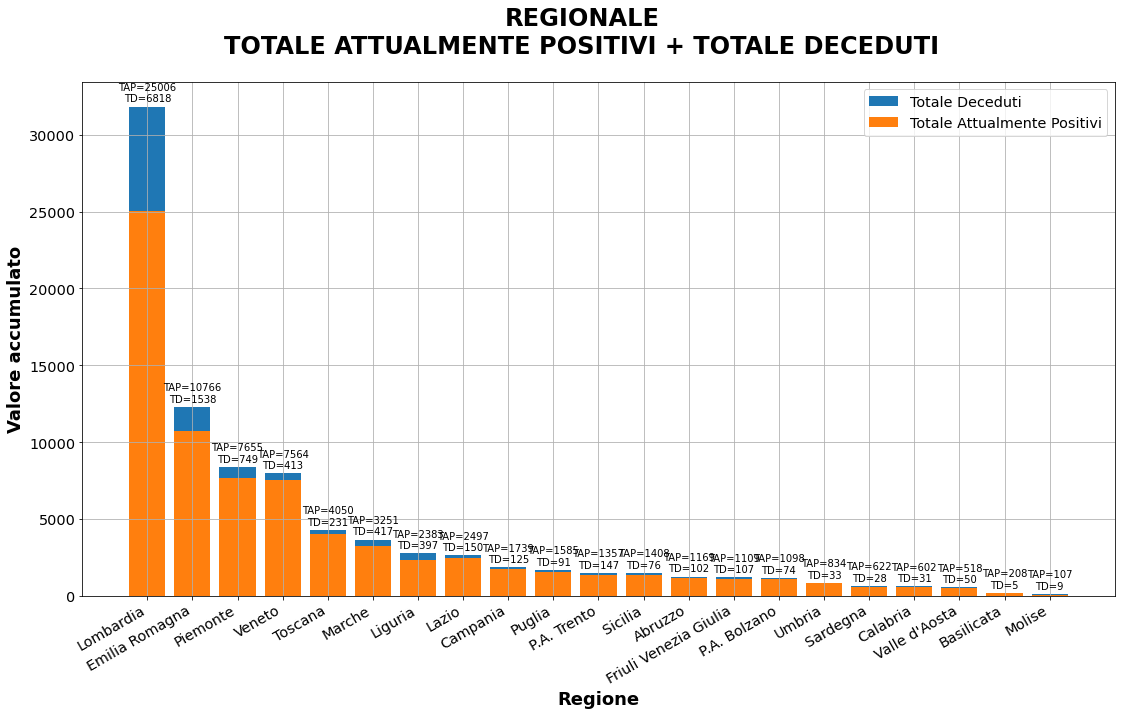

<HR>

In [107]:
fig, ax = plt.subplots()
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large', 'legend.fontsize': 'x-large'})
fig.set_size_inches(18.5, 10.5)
fig.suptitle('REGIONALE\nTOTALE ATTUALMENTE POSITIVI + TOTALE DECEDUTI', fontsize=24, fontweight='bold')
ax.set_xlabel('Regione', horizontalalignment='center', fontsize=18, fontweight='bold')
ax.set_ylabel('Valore accumulato', fontsize=18, fontweight='bold')

# first series
ax.bar(myRegions_T_sorted, myValues_TAP_TD_sorted, label="Totale Deceduti")
# second series
ax.bar(myRegions_T_sorted, myValues_TAP_sorted, label="Totale Attualmente Positivi")

## Rotate date labels automatically
fig.autofmt_xdate()

for idx, region in enumerate(myRegions_T_sorted):
    
    height_2 = myValues_TAP_TD_sorted[idx]
    label_2 = "TAP=" + str(myValues_TAP_sorted[idx]) + "\nTD=" + str(myValues_TAP_TD_sorted[idx] - myValues_TAP_sorted[idx])
    ax.annotate(label_2,
        (idx, height_2),
        xytext=(0, 5), 
        textcoords='offset points',
        ha='center')

ax.grid(True)
ax.legend()
plt.show()
printmd("<HR>")

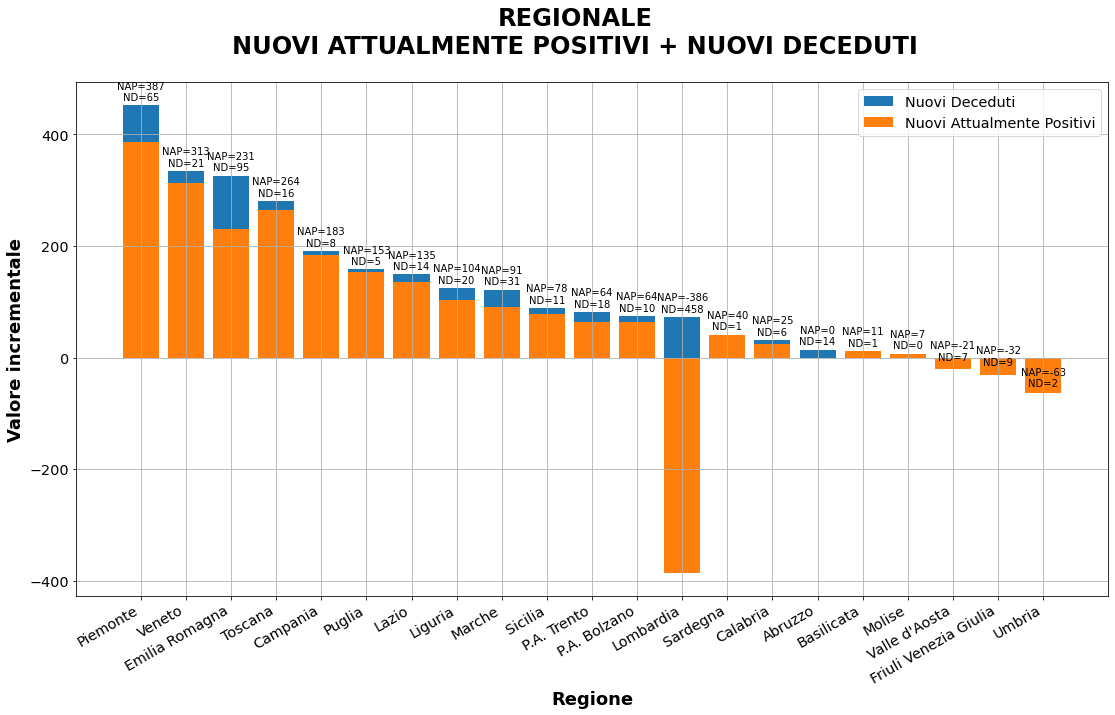

<HR>

In [108]:
fig, ax = plt.subplots()
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large', 'legend.fontsize': 'x-large'})
fig.set_size_inches(18.5, 10.5)
fig.suptitle('REGIONALE\nNUOVI ATTUALMENTE POSITIVI + NUOVI DECEDUTI', fontsize=24, fontweight='bold')
ax.set_xlabel('Regione', horizontalalignment='center', fontsize=18, fontweight='bold')
ax.set_ylabel('Valore incrementale', fontsize=18, fontweight='bold')

# first series
ax.bar(myRegions_N_sorted, myValues_NAP_ND_sorted, label="Nuovi Deceduti")
# second series
ax.bar(myRegions_N_sorted, myValues_NAP_sorted, label="Nuovi Attualmente Positivi")

## Rotate date labels automatically
fig.autofmt_xdate()

for idx, region in enumerate(myRegions_N_sorted):
    height_2 = myValues_NAP_ND_sorted[idx]
    label_2 = "NAP=" + str(myValues_NAP_sorted[idx]) + "\nND=" + str(myValues_NAP_ND_sorted[idx] - myValues_NAP_sorted[idx])
    ax.annotate(label_2,
        (idx, height_2),
        xytext=(0, 5), 
        textcoords='offset points',
        ha='center')

ax.grid(True)
ax.legend()
plt.show()
printmd("<HR>")


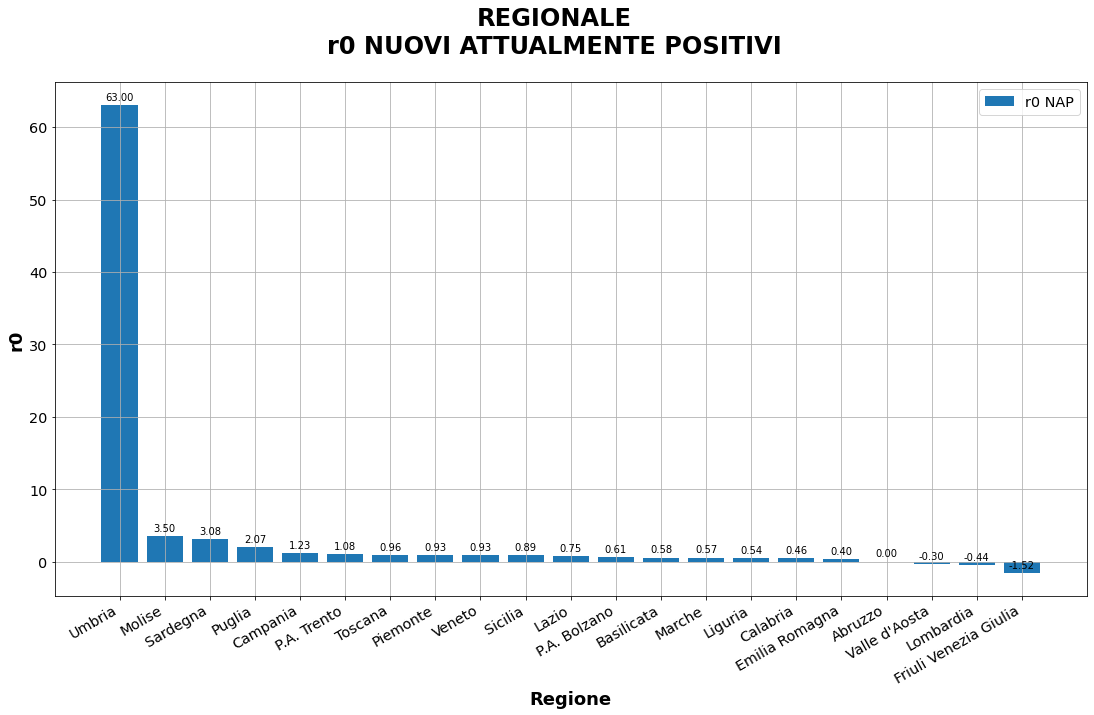

<HR>

In [109]:
fig, ax = plt.subplots()
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large', 'legend.fontsize': 'x-large'})
fig.set_size_inches(18.5, 10.5)
fig.suptitle('REGIONALE\nr0 NUOVI ATTUALMENTE POSITIVI', fontsize=24, fontweight='bold')
ax.set_xlabel('Regione', horizontalalignment='center', fontsize=18, fontweight='bold')
ax.set_ylabel('r0', fontsize=18, fontweight='bold')

# first series
ax.bar(myRegions_r0_sorted, r0_NAP_sorted, label="r0 NAP")

## Rotate date labels automatically
fig.autofmt_xdate()

for idx, region in enumerate(myRegions_r0_sorted):
    height = r0_NAP_sorted[idx]
    label = "{:.2f}".format(r0_NAP_sorted[idx])
    ax.annotate(label,
        (idx, height),
        xytext=(0, 5), 
        textcoords='offset points',
        ha='center')

ax.grid(True)
ax.legend()
plt.show()
printmd("<HR>")

In [110]:
def show_chart_for_region(df_reg, regione):
    # data staging
    df_regione = df_reg[df_reg['denominazione_regione'] == regione]
    df2 = df_regione['deceduti']
    nuovi_deceduti = df2.diff(periods=1);
    nuovi_deceduti.iloc[0] = 0

    #myDates = [datetime.datetime.strptime(d,"%Y-%m-%d %H:%M:%S").date() for d in df_regione['data']]
    myDates = [datetime.datetime.strptime(d,"%Y-%m-%dT%H:%M:%S").date() for d in df_regione['data']]

    myValues_TAP_TD = [int(x)+int(y) for x,y in zip(df_regione['totale_attualmente_positivi'], df_regione['deceduti'])]
    myValues_TAP = [int(x) for x in df_regione['totale_attualmente_positivi']]

    myValues_NAP_ND = [int(x)+int(y) for x,y in zip(df_regione['nuovi_attualmente_positivi'], nuovi_deceduti)]
    myValues_NAP = [int(x) for x in df_regione['nuovi_attualmente_positivi']]
    
    bar_chart(title = 'DATI REGIONALI: {}\nTOTALE ATTUALMENTE POSITIVI + TOTALE DECEDUTI'.format(regione),
          xlabel = 'Giorno',
          ylabel = 'Valore Accumulato',
          xseries = myDates,
          yseries1 = myValues_TAP_TD,
          label1 = "Totale Deceduti",
          yseries2 = myValues_TAP,
          label2 = "Totale Attualmente Positivi", 
          xdates = True)
    printmd("<HR>")
    
    bar_chart(title = 'DATI REGIONALI: {}\nNUOVI ATTUALMENTE POSITIVI + NUOVI DECEDUTI'.format(regione),
          xlabel = 'Giorno',
          ylabel = 'Valore Incrementale',
          xseries = myDates,
          yseries1 = myValues_NAP_ND,
          label1 = "Nuovi Deceduti",
          yseries2 = myValues_NAP,
          label2 = "Nuovi Attualmente Positivi", 
          xdates = True)
    printmd("<HR>")

In [111]:
dropdown_region = widgets.Dropdown(options = myRegions_T_sorted)

output_region = widgets.Output()


@output_region.capture()
def dropdown_region_eventhandler(change):
    regione = change.new
    #regione = myRegions_T_sorted[change.new['index']]

    output_region.clear_output()
    printmd("<span style='color:black;font-weight:bold;font-size:18px;'>DATI REGIONALI: {}</span><BR>".format(regione.upper()))


    summary_dict = {'totale_casi': "Totale casi", 
                    'totale_attualmente_positivi': "Totale attualmente positivi",
                   'nuovi_attualmente_positivi': "Nuovi attualmente positivi",
                   'deceduti': "Deceduti",
                   'terapia_intensiva': "Terapia Intensiva",
                   'ricoverati_con_sintomi': "Ricoverati con sintomi",
                   'totale_ospedalizzati': "Totale ospedalizzati",
                   'isolamento_domiciliare': "Isolamente domiciliare",
                   'dimessi_guariti': "Dimessi guariti",
                   'tamponi': "Tamponi"}

    printmd("<span style='color:black;font-weight:bold;font-size:20px;'>Aggiornamento: </span><span style='color:blue;font-weight:bold;font-size:20px'>{}</span>".format(latest_date))
    for key in summary_dict:
        update_string = getlatest(df_reg[df_reg['denominazione_regione'] == regione], key)
        printmd("<span style='color:black;font-weight:bold;font-size:18px'>{}:  </span><span style='color:blue;font-weight:bold;font-size:20px'>{}</span>".format(summary_dict[key], update_string))

    show_chart_for_region(df_reg, regione)
    
dropdown_region.observe(dropdown_region_eventhandler, names = 'value')

display(dropdown_region)
display(output_region)
class Obj(object): 
    new = None
o = Obj()
setattr(o, 'new', myRegions_T_sorted[0])
dropdown_region_eventhandler(o)
printmd("<HR>")

Dropdown(options=('Lombardia', 'Emilia Romagna', 'Piemonte', 'Veneto', 'Toscana', 'Marche', 'Liguria', 'Lazio'…

Output()

<HR>

In [112]:
#np.unique(df_reg['denominazione_regione'])

In [113]:
# simulazione sigmoide regionale

df_plot = pd.DataFrame()

origin_datetime = datetime.datetime.strptime(df['data'][0], '%Y-%m-%dT%H:%M:%S')
regioni = {'Lombardia': None, 'Veneto': None, 'Piemonte': None, 'Emilia Romagna': None,
          'Abruzzo': None, 'Basilicata': None, 'Calabria': None, 'Campania': None,
       'Friuli Venezia Giulia': None, 'Lazio': None, 'Liguria': None, 'Marche': None,
       'Molise': None, 'P.A. Bolzano': None, 'P.A. Trento': None, 'Puglia': None,
       'Sardegna': None, 'Sicilia': None, 'Toscana': None, 'Umbria': None, "Valle d'Aosta": None }
#df.head()

VERBOSE = 0

min_offset = 99999999999
for regione in regioni:
    if VERBOSE:
        print("Processing: {}".format(regione))
    cc = df_reg[df_reg['denominazione_regione'] == regione]['totale_casi'].tolist()
    if VERBOSE:
        print("Initial Len: {}".format(len(cc)))
    regioni[regione] = 0
    while cc[0] < 100:
        cc = np.delete(cc, 0)
        cc = np.append(cc, [0])
        regioni[regione] += 1
    if VERBOSE:
        print("Final Len: {}, steps: {}".format(len(cc), regioni[regione]))
    df_plot[regione] = cc
    if regioni[regione] < min_offset:
        min_offset = regioni[regione]

regioni_sort = {k: v for k, v in sorted(regioni.items(), key=lambda item: item[1])}
for regione in regioni_sort:
    print("{:20} --> ritardo: {} gg".format(regione[:20], regioni_sort[regione]))

Lombardia            --> ritardo: 0 gg
Veneto               --> ritardo: 3 gg
Emilia Romagna       --> ritardo: 4 gg
Piemonte             --> ritardo: 10 gg
Marche               --> ritardo: 10 gg
Toscana              --> ritardo: 12 gg
Campania             --> ritardo: 13 gg
Lazio                --> ritardo: 14 gg
Liguria              --> ritardo: 14 gg
Friuli Venezia Giuli --> ritardo: 15 gg
P.A. Bolzano         --> ritardo: 17 gg
P.A. Trento          --> ritardo: 17 gg
Puglia               --> ritardo: 17 gg
Sicilia              --> ritardo: 17 gg
Abruzzo              --> ritardo: 19 gg
Umbria               --> ritardo: 19 gg
Sardegna             --> ritardo: 21 gg
Valle d'Aosta        --> ritardo: 21 gg
Calabria             --> ritardo: 22 gg
Basilicata           --> ritardo: 30 gg
Molise               --> ritardo: 31 gg


In [114]:
df_plot.head()

,Lombardia,Veneto,Piemonte,Emilia Romagna,Abruzzo,Basilicata,Calabria,Campania,Friuli Venezia Giulia,Lazio,...,Marche,Molise,P.A. Bolzano,P.A. Trento,Puglia,Sardegna,Sicilia,Toscana,Umbria,Valle d'Aosta
0,172,111,108,145,112,113,114,101,116,102,...,124,103,104,107,104,107,115,113,107,105
1,240,151,143,217,137,134,129,120,126,116,...,159,109,125,163,129,117,130,166,143,136
2,258,191,207,285,176,151,169,127,167,150,...,207,123,173,206,166,134,156,208,164,165
3,403,263,360,335,229,182,207,154,257,200,...,272,127,204,378,230,206,188,264,197,215
4,531,273,350,420,263,202,235,179,301,277,...,323,134,241,378,230,293,213,320,247,264


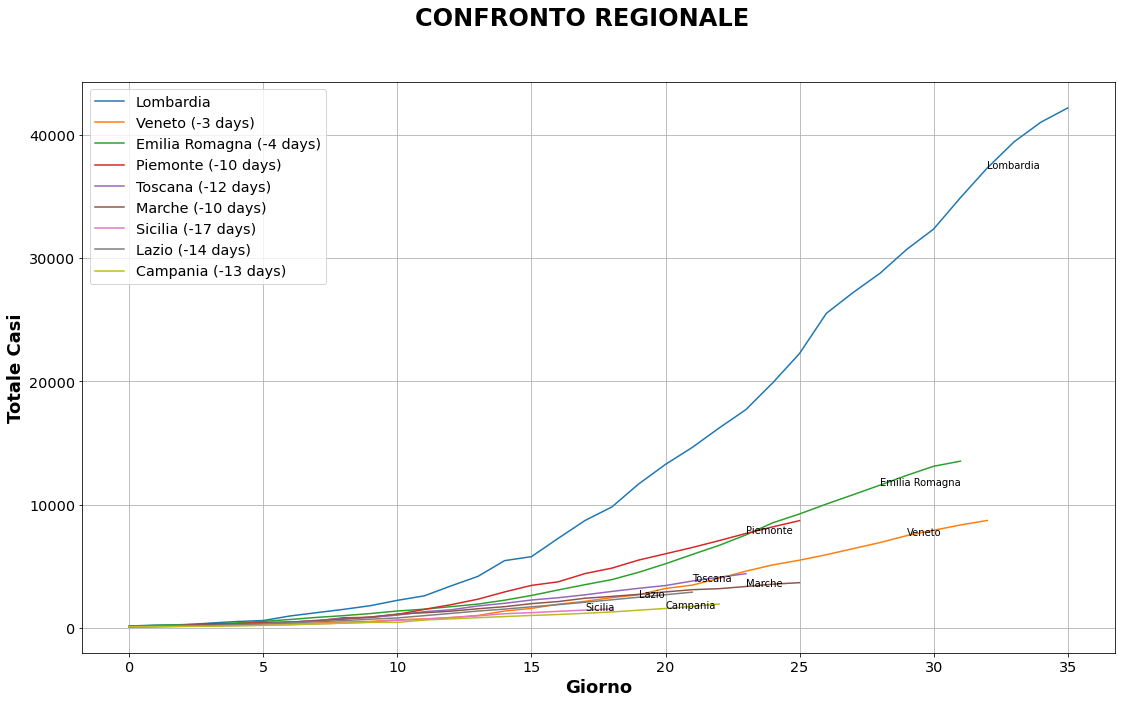

In [115]:


df_sim = pd.DataFrame()

A = {'Lombardia': 40000.0, 'Veneto': 40000.0, 'Piemonte': 40000.0, 'Emilia Romagna': 40000.0, 'Toscana': 40000.0, 'Marche': 40000.0}
D = {'Lombardia': 22.0, 'Veneto': 22.0, 'Piemonte': 22.0, 'Emilia Romagna': 22.0, 'Toscana': 22.0, 'Marche': 22.0}
T = {'Lombardia': 5.4, 'Veneto': 5.4, 'Piemonte': 5.4, 'Emilia Romagna': 5.4, 'Toscana': 5.4, 'Marche': 5.4}

def iterate_mse(df_plot, regioni, regione, param_name, A, D, T):
    epsilon_reference = {'A': 1000, 'D': 0.1, 'T': 0.2}
    max_loop = {'A': 100, 'D': 100, 'T': 100}
    epsilon = {'A': 0, 'D': 0, 'T': 0}
    epsilon[param_name] = epsilon_reference[param_name]
    LAST_MOVE = None
    if VERBOSE:
        print("XXXXXXXXX BEGIN OF ITERATION {} XXXXXXXXX".format(param_name))
    for loop in range(0,max_loop[param_name]):
        relevant_length = len(df_plot[regione])-regioni[regione]
        simulation_length = max(len(df_plot[regione]), 50)
        # zero
        # the sim array is calculated with full length len(df_plot[country])
        sim_0 = [A[regione] / (1+math.exp((D[regione]-x)/T[regione])) for x in range(0,simulation_length)]
        # the mse is calculated only based on the relevant length and normalized
        mse_0 = ((df_plot[regione][0:relevant_length]-sim_0[0:relevant_length])**2).sum() / relevant_length
        # D+
        sim_plus = [(A[regione] + epsilon['A']) / (1+math.exp((D[regione] + epsilon['D'] - x)/(T[regione] + epsilon['T']))) for x in range(0,simulation_length)]
        mse_plus = ((df_plot[regione][0:relevant_length]-sim_plus[0:relevant_length])**2).sum() / relevant_length
        # D-
        sim_minus = [(A[regione] - epsilon['A']) / (1+math.exp((D[regione] - epsilon['D'] - x)/(T[regione] - epsilon['T']))) for x in range(0,simulation_length)]
        mse_minus = ((df_plot[regione][0:relevant_length]-sim_minus[0:relevant_length])**2).sum() / relevant_length
        if VERBOSE:
            print("{:3d} {} mse_minus = {:.3e} ; mse_0 = {:.3e} ; mse_plus = {:.3e}".format(loop, regione, mse_minus, mse_0, mse_plus))
        if mse_plus < mse_0:
            if LAST_MOVE == "MINUS":
                    epsilon[param_name] /= 2
                    if VERBOSE:
                        print("* {} Epsilon / 2 : {:.4f}".format(param_name, epsilon[param_name]))
            A[regione] += epsilon["A"]
            D[regione] += epsilon["D"]
            T[regione] += epsilon["T"]
            if VERBOSE:
                print(" {}  >>>>>>".format(param_name))
            LAST_MOVE = "PLUS"
        elif mse_minus < mse_0:
            if LAST_MOVE == "PLUS":
                    epsilon[param_name] /= 2
                    if VERBOSE:
                        print("* {} Epsilon / 2 : {:.4f}".format(param_name, epsilon[param_name]))
            A[regione] -= epsilon["A"]
            D[regione] -= epsilon["D"]
            T[regione] -= epsilon["T"]
            if VERBOSE:
                print(" {}  <<<<<<".format(param_name))
            LAST_MOVE = "MINUS"
        else:
            if VERBOSE:
                print("Local min found --> Breaking after {} loops".format(loop+1))
            break
    if VERBOSE:
        print("{} {} --> mse = {:.1e} - Sim [0] = {:.0f}".format(regione, param_name, mse_0, sim_0[0]))
        print("XXXXXXXXX END OF ITERATION {} XXXXXXXXX".format(param_name))
    return sim_0


#RegValues_TAP = df_reg["totale_attualmente_positivi"]
df_reg.head()

for regione in ['Lombardia', 'Veneto', 'Emilia Romagna', 'Piemonte', 'Toscana', 'Marche']:
    for big_loop in range(0,10):
        sim_0 = iterate_mse(df_plot, regioni, regione, "A", A, D, T)
        if VERBOSE:
            print("A = {:.3f} ; D = {:.3f} ; T = {:.3f}".format(A[regione], D[regione], T[regione]))
        sim_0 = iterate_mse(df_plot, regioni, regione, "D", A, D, T)
        if VERBOSE:
            print("A = {:.3f} ; D = {:.3f} ; T = {:.3f}".format(A[regione], D[regione], T[regione]))
        sim_0 = iterate_mse(df_plot, regioni, regione, "T", A, D, T)
        if VERBOSE:
            print("A = {:.3f} ; D = {:.3f} ; T = {:.3f}".format(A[regione], D[regione], T[regione]))

    df_sim[regione] = sim_0

fig, ax = plt.subplots()
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large', 'legend.fontsize': 'x-large'})
fig.set_size_inches(18.5, 10.5)
fig.suptitle('CONFRONTO REGIONALE', fontsize=24, fontweight='bold')
ax.set_xlabel('Giorno', horizontalalignment='center', fontsize=18, fontweight='bold')
ax.set_ylabel('Totale Casi', fontsize=18, fontweight='bold')

#for regione in regioni:
for regione in ['Lombardia', 'Veneto', 'Emilia Romagna', 'Piemonte', 'Toscana', 'Marche', 'Sicilia', 'Lazio', 'Campania']:
    if regioni[regione] == min_offset:
        ax.plot(df_plot[regione][0:len(df_plot[regione])-regioni[regione]], label="{}".format(regione))
    else:
        ax.plot(df_plot[regione][0:len(df_plot[regione])-regioni[regione]], label="{} (-{} days)".format(regione, regioni[regione] - min_offset))
    text_x_pos = int(.9 * (len(df_plot[regione])-regioni[regione]))
    text_y_pos = int(df_plot[regione][text_x_pos])
    plt.text(text_x_pos, text_y_pos, regione)


"""
for regione in ['Lombardia', 'Veneto', 'Emilia Romagna', 'Piemonte', 'Marche']:
    ax.plot(df_sim[regione], label = "{} sim".format(regione), linestyle='dashed')
    text_x_pos = int(.9 * len(df_sim[regione]))
    text_y_pos = int(df_sim[regione][text_x_pos])
    plt.text(text_x_pos, text_y_pos, regione)

    peak_datetime = origin_datetime + datetime.timedelta(days=regioni[regione] + D[regione])
    print("{:10} --> picco: {} ; Totale casi finale = {:8.0f} ; Costante di tempo = {:.1f} gg".format(regione[:10], peak_datetime.strftime("%b %d"), A[regione], T[regione]))
"""
ax.grid()
ax.legend()

plt.show()



Lombardia  --> picco: Mar 20 ; Totale casi finale =    44000 ; Costante di tempo = 4.8 gg
Veneto     --> picco: Mar 21 ; Totale casi finale =     9000 ; Costante di tempo = 4.4 gg
Emilia Rom --> picco: Mar 22 ; Totale casi finale =    15000 ; Costante di tempo = 4.8 gg
Piemonte   --> picco: Mar 27 ; Totale casi finale =    14000 ; Costante di tempo = 5.4 gg
Marche     --> picco: Mar 28 ; Totale casi finale =     7000 ; Costante di tempo = 7.4 gg


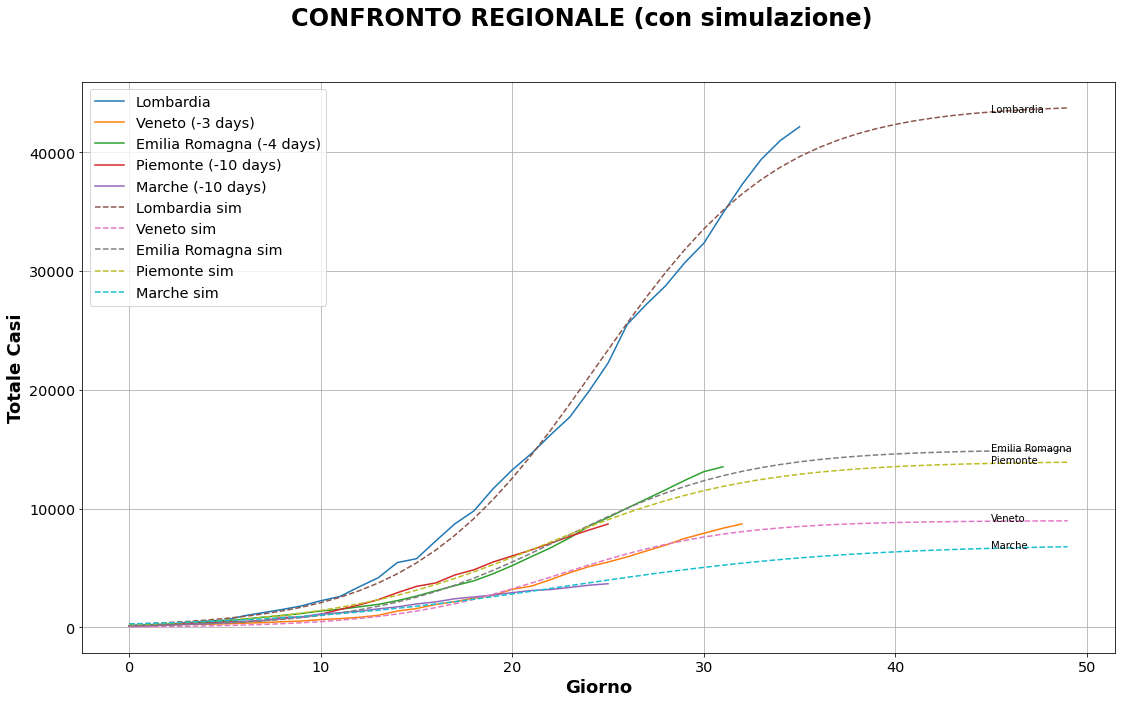

In [116]:
fig, ax = plt.subplots()
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large', 'legend.fontsize': 'x-large'})
fig.set_size_inches(18.5, 10.5)
fig.suptitle('CONFRONTO REGIONALE (con simulazione)', fontsize=24, fontweight='bold')
ax.set_xlabel('Giorno', horizontalalignment='center', fontsize=18, fontweight='bold')
ax.set_ylabel('Totale Casi', fontsize=18, fontweight='bold')

#for regione in regioni:
for regione in ['Lombardia', 'Veneto', 'Emilia Romagna', 'Piemonte', 'Marche']:
    if regioni[regione] == min_offset:
        ax.plot(df_plot[regione][0:len(df_plot[regione])-regioni[regione]], label="{}".format(regione))
    else:
        ax.plot(df_plot[regione][0:len(df_plot[regione])-regioni[regione]], label="{} (-{} days)".format(regione, regioni[regione] - min_offset))

for regione in ['Lombardia', 'Veneto', 'Emilia Romagna', 'Piemonte', 'Marche']:
    ax.plot(df_sim[regione], label = "{} sim".format(regione), linestyle='dashed')
    text_x_pos = int(.9 * len(df_sim[regione]))
    text_y_pos = int(df_sim[regione][text_x_pos])
    plt.text(text_x_pos, text_y_pos, regione)

    peak_datetime = origin_datetime + datetime.timedelta(days=regioni[regione] + D[regione])
    print("{:10} --> picco: {} ; Totale casi finale = {:8.0f} ; Costante di tempo = {:.1f} gg".format(regione[:10], peak_datetime.strftime("%b %d"), A[regione], T[regione]))
ax.grid()
ax.legend()

plt.show()



In [117]:
# provincial data staging
PROV_JSON_URL = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-province.json"

with urllib.request.urlopen(PROV_JSON_URL) as url:
	data_prov = json.loads(url.read().decode())

df_prov = pd.DataFrame.from_dict(data_prov)


Provinces = ["Milano", "Bergamo", "Brescia", "Lodi", "Mantova"]


In [118]:
printmd("<span style='color:red;font-weight:bold;font-size:26px;'>DATI PROVINCIALI </span><BR>")

<span style='color:red;font-weight:bold;font-size:26px;'>DATI PROVINCIALI </span><BR>

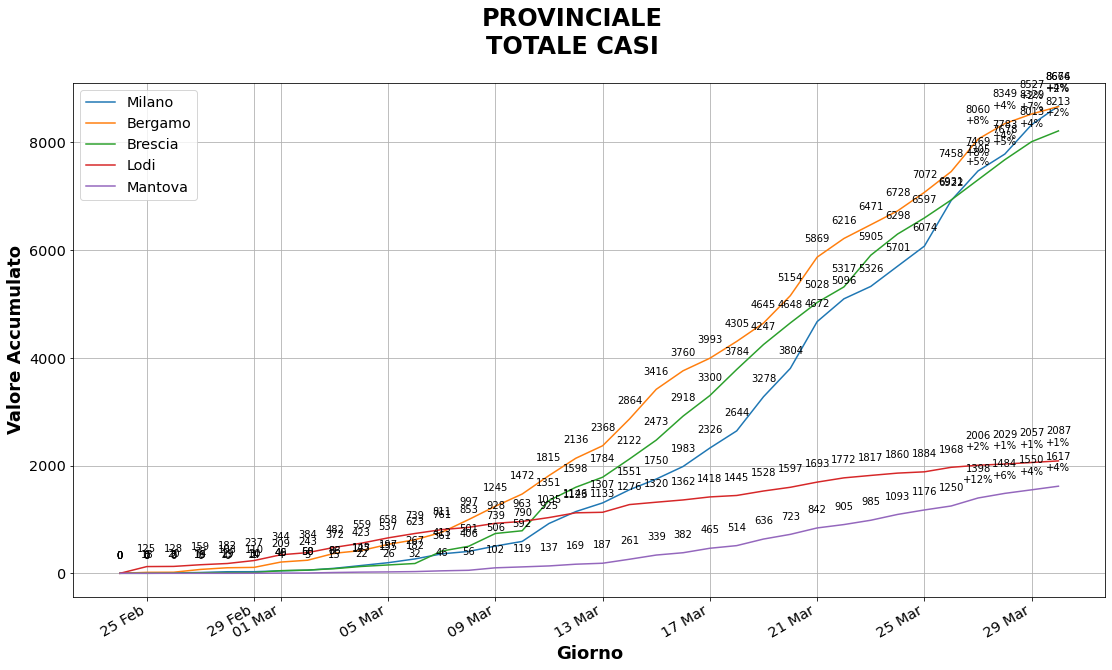

<HR>

In [119]:
fig, ax = plt.subplots()
plt.rcParams.update({'xtick.labelsize': 'x-large', 'ytick.labelsize': 'x-large', 'legend.fontsize': 'x-large'})
fig.set_size_inches(18.5, 10.5)
fig.suptitle('PROVINCIALE\nTOTALE CASI', fontsize=24, fontweight='bold')
ax.set_xlabel('Giorno', horizontalalignment='center', fontsize=18, fontweight='bold')
ax.set_ylabel('Valore Accumulato', fontsize=18, fontweight='bold')

for provincia in Provinces:
    #myDates = [datetime.datetime.strptime(d,"%Y-%m-%d %H:%M:%S").date() for d in df_prov[df_prov['denominazione_provincia'] == provincia]['data']]
    myDates = [datetime.datetime.strptime(d,"%Y-%m-%dT%H:%M:%S").date() for d in df_prov[df_prov['denominazione_provincia'] == provincia]['data']]
    myValues = df_prov[df_prov['denominazione_provincia'] == provincia]["totale_casi"].values
    ax.plot(myDates, myValues, label=provincia)
    for idx,d in enumerate(myDates):
        x = myDates[idx]
        y = myValues[idx]
        if idx < len(myDates)-4:
            label = "{}".format(myValues[idx])
        else:
            label = "{}\n+{:.0f}%".format(myValues[idx], 100*(myValues[idx]-myValues[idx-1])/myValues[idx-1])

        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,15), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

myFmt = DateFormatter("%d %b")
ax.xaxis.set_major_formatter(myFmt)

## Rotate date labels automatically
fig.autofmt_xdate()

ax.grid(True)
ax.legend()

plt.show()
printmd("<HR>")

In [120]:
timestamp = datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")
printmd("<span style='color:black;font-size:12px'>Notebook generato il {}</span>".format(timestamp))

<span style='color:black;font-size:12px'>Notebook generato il 03/30/2020, 18:20:09</span>